In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
import pdb
import json
from math import sqrt

In [2]:
file_csv = '/home/mmp/Documents/script_output/CDKL5_ORGANOIDS_T2/Network_outputs/Compiled_Networks.csv'

data_df = pd.read_csv(file_csv)


In [3]:
data_df

,Run_ID,DIV,Time,Chip_ID,IBI,COVIBI,Burst_Peak,COVBurstPeak,Number_Bursts,Spike_per_Burst,Active_Electrodes,Mean_FiringRate,Mean_SpikeAmplitude,TYPE
0,5,7,01-Dec-2023 12:18:32,21860,7.653684,50.628135,5.329945,27.648568,39,2446.205128,1.86,1.250068,31.616030,CDKL5 PROBD
1,7,7,01-Dec-2023 12:58:16,21945,4.883333,49.076317,3.927868,40.918689,61,242.000000,0.33,1.071970,29.335614,CDKL5 PROBD
2,9,7,01-Dec-2023 13:46:42,21613,4.433438,63.655935,3.675154,53.102275,65,738.600000,0.78,1.060650,32.555148,CDKL5 PROBD
3,11,7,01-Dec-2023 14:21:51,21644,4.321471,102.298275,3.582731,33.049112,69,3348.275362,2.28,1.402769,30.586017,CDKL5 PROBD
4,13,13,07-Dec-2023 10:57:32,21644,7.790811,67.146485,5.543731,34.025101,38,3620.578947,3.19,1.397070,32.315572,CDKL5 PROBD
5,15,13,07-Dec-2023 11:37:23,21613,6.665000,59.528977,5.184863,35.657627,45,4786.088889,3.84,1.443999,26.093712,CDKL5 PROBD
6,17,13,07-Dec-2023 12:18:32,21860,6.311064,21.712541,3.985490,12.758186,48,3337.000000,4.42,0.946883,27.058310,CDKL5 PROBD
7,19,13,07-Dec-2023 13:00:26,21945,7.965000,46.318856,6.779472,22.016931,37,2007.000000,1.60,0.918657,24.179582,CDKL5 PROBD
8,22,20,14-Dec-2023 12:06:04,21613,5.657308,48.862399,5.724882,31.089840,53,3316.396226,3.39,1.330236,24.902346,CDKL5 PROBD
9,24,20,14-Dec-2023 12:46:28,21644,7.420513,46.793805,6.294052,19.720178,40,5301.275000,4.50,1.403272,23.005923,CDKL5 PROBD


In [4]:
df = data_df.replace(np.NaN,0.0)

In [6]:
div = df['DIV'].unique()
print(div)

[ 7 13 20]


In [8]:
unique_genotypes = df['TYPE'].unique()
unique_genotypes

array(['CDKL5 PROBD'], dtype=object)

In [9]:
#unique_genotypes=['WT1','WT', 'HET1', 'HET']
colors = ['lightsteelblue','cornflowerblue','royalblue','lightcoral','indianred','brown']
colors = ['royalblue','brown']

In [10]:
unique_genotypes

array(['CDKL5 PROBD'], dtype=object)

In [ ]:
output_types =['Number_Bursts','Burst_Peak','Spike_per_Burst','IBI','Mean_FiringRate','Mean_SpikeAmplitude'
               ]
for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    #output_type='Number_Bursts'
    # Print the number of unique genotypes
    print(f"Number of unique Genotypes: {total_genotypes}")

    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    print(unique_genotypes)
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) & (df['NeuronType'].str.strip() == genotype)]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['Chip_ID']))
            well_arrays[genotype].append(np.array(temp_df['Well']))

    #pdb.set_trace()
    w = len(div)/32  # bar width
    gaplength = 1/(len(unique_genotypes)+2)
    # Create x-coordinates of bars
    x_day = [d for d in div]
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    x_d = list(range(0, len(div)))

    # Assign x-coordinates for each genotype
    for i, genotype in enumerate(unique_genotypes):
        for x in x_d:
            
            x_genotype[genotype].append(x + (gaplength*i+1))


    # Initialize plot
    fig, ax = plt.subplots()
    # Generate a list of distinct colors based on the number of genotypes
    #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
    #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
    # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
    # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
    # Plot data for each genotype
    mean_data_all ={}
    yerr_data_all = {}
    n_data_all={}
    #breakpoint()
    #pdb.set_trace()
    for i,genotype in enumerate(unique_genotypes):
        #breakpoint()
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        #print("type: ",type(genotype))
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        # Save statistics to file
        output_file = f"intermediate_files/{output_type}_{genotype}_statistics.txt"
        with open(output_file, 'w') as file:
            file.write(f"{genotype} Statistics\n")
            file.write("Mean: " + ", ".join([str(m) for m in mean_data]) + "\n")
            file.write("SEM: " + ", ".join([str(sem) for sem in yerr_data]) + "\n")
            file.write("Sample Size (n): " + ", ".join([str(n_data)]) + "\n")
            
        # Plot bars
        #transparency value 
        alpha_value = 0.5
        ax.bar(x_genotype[genotype],
            height=mean_data,
            yerr=yerr_data,
            capsize=3,
            width=gaplength,
            color=colors[i],
            edgecolor='black',
            ecolor='black',
            alpha=alpha_value,label=genotype)
        #pdb.set_trace()
        # Plot scatter points
        #breakpoint()
        for j in range(len(x_genotype[genotype])):
            #pdb.set_trace()
            # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
    # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
            combined_data = [chip + str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

            # # Check if the concatenated string is in track_chips, and set the marker accordingly
            # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
            # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

            # Use the marker in the scatter plot
            jitter_amount=0.02
            for k in range(len(y_data[j])):
                #pdb.set_trace()
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=7,
                    color=colors[i],
                    marker='o'
                        )


    # # Calculate maximum y-value for plotting significance
    # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
    # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

    #Perform and plot t-tests between all pairs of genotype
    #pdb.set_trace()
    for i in range(len(x_d)):
        #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
        maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    #pdb.set_trace()
                    #print("mean_data_all",mean_data_all[genotype1])
                    #print("type:",type(genotype1))
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    # degrees of freedom
                    degreef = n1+n2 - 2
                    alpha=0.05
                    # calculate the critical value
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    # calculate the p-vallue
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1,sem1,mean2,sem2,p_value])

                    # Plot significance
                    #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    
                    ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                    count = count +1

                    with open(output_file, 'a') as file:
                                file.write(f"P values:{p_values} \n")


    # Axis scaling and labeling
    #xmin = 0
    #xmax = (max(df['DIV']) - xmin)*1.25
    #ymin = 0
    #ymax = (max(df[output_type]) - ymin)*1.4
    #pdb.set_trace()
    plt.title(output_type)
    plt.xlabel('DIV')
    plt.ylabel(output_type)
    plt.xticks(list(map(lambda x: x + 1+(2*gaplength), x_d)), x_day)
    #ax.set_xticks(x_ticks)

    # Set the corresponding DIV labels for each tick position
    #ax.set_xticklabels(div)
    #plt.axis([xmin, len(div) + 1, ymin, ymax])
    
    plt.legend(title='type',loc='upper right', fontsize='small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.2, 1))
    #ax.legend(labels = ['ADNP2 WT1','ADNP3 WT', 'ADNP2 HET1', 'ADNP3 HET'])

Number of unique Genotypes: 1
[1, 2, 3]
[7, 13, 20]
Number of unique Genotypes: 1
[1, 2, 3]
[7, 13, 20]
Number of unique Genotypes: 1
[1, 2, 3]
[7, 13, 20]
Number of unique Genotypes: 1
[1, 2, 3]
[7, 13, 20]
Number of unique Genotypes: 1
[1, 2, 3]
[7, 13, 20]
Number of unique Genotypes: 1
[1, 2, 3]
[7, 13, 20]
Number of unique Genotypes: 1
[1, 2, 3]
[7, 13, 20]


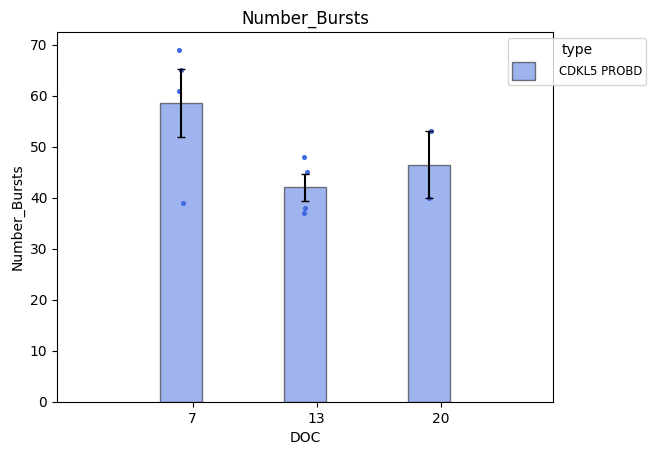

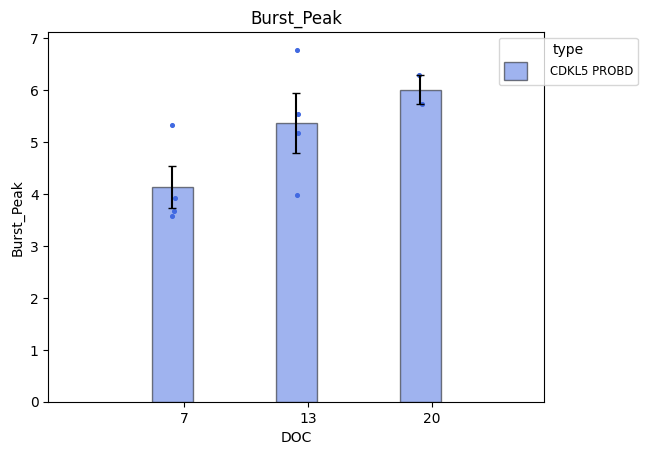

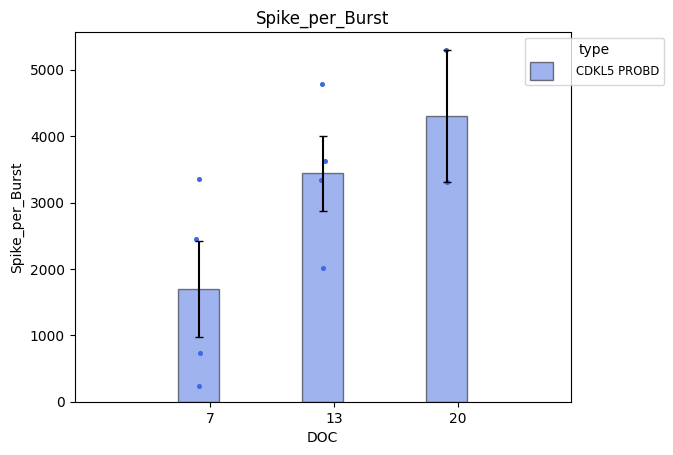

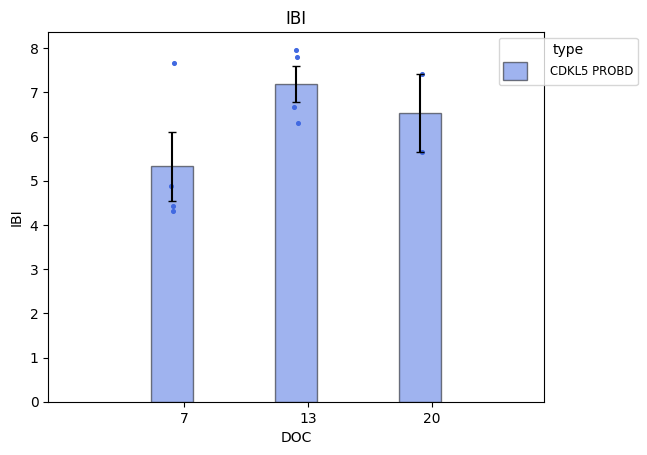

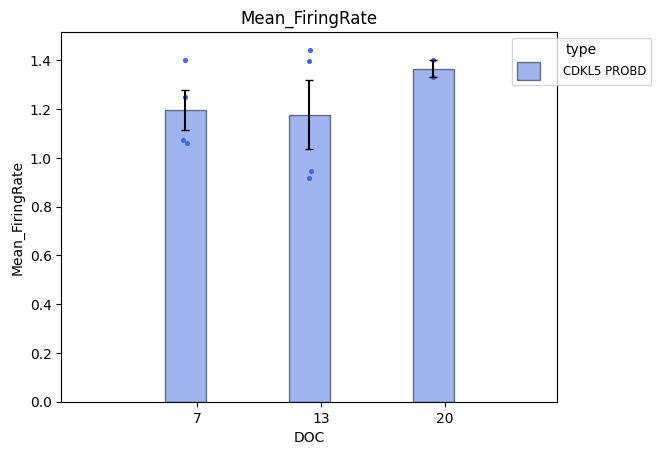

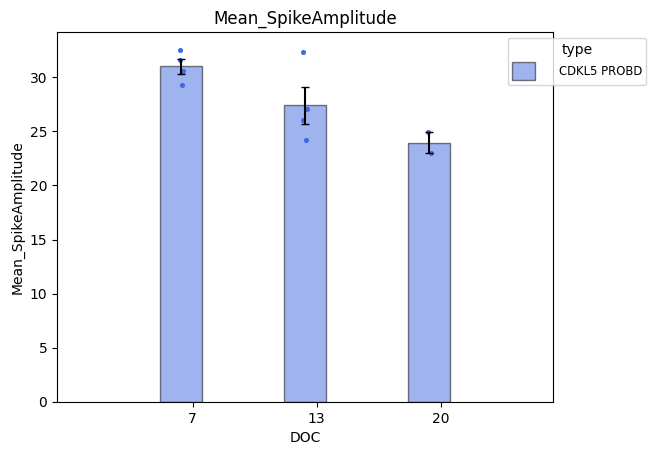

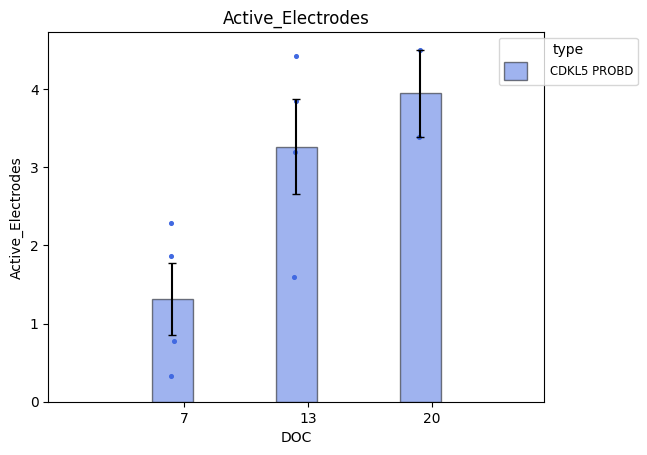

In [13]:
output_types =['Number_Bursts','Burst_Peak','Spike_per_Burst','IBI','Mean_FiringRate','Mean_SpikeAmplitude'
               ,'Active_Electrodes']
for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    #output_type='Number_Bursts'
    # Print the number of unique genotypes
    print(f"Number of unique Genotypes: {total_genotypes}")

    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    #print(unique_genotypes)
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) & (df['TYPE'].str.strip() == genotype)]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['Chip_ID']))
            #well_arrays[genotype].append(np.array(temp_df['Well']))
    total_div = len(div)
    #pdb.set_trace()
    w = total_div/32  # bar width
    gaplength = 1/(len(unique_genotypes)+2)
    # Create x-coordinates of bars
    x_day = [int(d) for d in div]
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    x_d = list(range(1, total_div+1))
    print(x_d)
    # Assign x-coordinates for each genotype
    for i, genotype in enumerate(unique_genotypes):
        for x in x_d:
            
            x_genotype[genotype].append(x + gaplength*i+1)


    # Initialize plot
    fig, ax = plt.subplots()
    # Generate a list of distinct colors based on the number of genotypes
    #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
    #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
    # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
    # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
    # Plot data for each genotype
    mean_data_all ={}
    yerr_data_all = {}
    n_data_all={}
    #breakpoint()
    #pdb.set_trace()
    for i,genotype in enumerate(unique_genotypes):
        #breakpoint()
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        #welly_data = well_arrays[genotype]
        #print("type: ",type(genotype))
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        # Save statistics to file
        output_file = f"intermediate_files/{output_type}_{genotype}_statistics.txt"
        with open(output_file, 'w') as file:
            file.write(f"{genotype} Statistics\n")
            file.write("Mean: " + ", ".join([str(m) for m in mean_data]) + "\n")
            file.write("SEM: " + ", ".join([str(sem) for sem in yerr_data]) + "\n")
            file.write("Sample Size (n): " + ", ".join([str(n_data)]) + "\n")
            
        # Plot bars
        #transparency value 
        alpha_value = 0.5
        ax.bar(x_genotype[genotype],
            height=mean_data,
            yerr=yerr_data,
            capsize=3,
            width=gaplength,
            color=colors[i],
            edgecolor='black',
            ecolor='black',
            alpha=alpha_value,label=genotype)
        #pdb.set_trace()
        # Plot scatter points
        #breakpoint()
        for j in range(len(x_genotype[genotype])):
            #pdb.set_trace()
            # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
    # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
            #combined_data = [chip + str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

            # # Check if the concatenated string is in track_chips, and set the marker accordingly
            # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
            # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

            # Use the marker in the scatter plot
            jitter_amount=0.02
            for k in range(len(y_data[j])):
                #pdb.set_trace()
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=7,
                    color=colors[i],
                    marker='o'
                        )


    # # Calculate maximum y-value for plotting significance
    # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
    # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

    #Perform and plot t-tests between all pairs of genotype
    #pdb.set_trace()
    for i in range(len(x_d)):
        #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
        maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    #pdb.set_trace()
                    #print("mean_data_all",mean_data_all[genotype1])
                    #print("type:",type(genotype1))
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    # degrees of freedom
                    degreef = n1+n2 - 2
                    alpha=0.05
                    # calculate the critical value
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    # calculate the p-vallue
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1,sem1,mean2,sem2,p_value])

                    # Plot significance
                    #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    
                    ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                    count = count +1

                    with open(output_file, 'a') as file:
                                file.write(f"P values:{p_values} \n")


    # Axis scaling and labeling
    #xmin = 0
    #xmax = (max(df['DIV']) - xmin)*1.25
    #ymin = 0
    #ymax = (max(df[output_type]) - ymin)*1.4
    #pdb.set_trace()
    plt.title(output_type)
    plt.xlabel('DOC')
    plt.ylabel(output_type)
    print(x_day)
    plt.xticks(list(map(lambda x: x + 1+w, x_d)), x_day)
    #ax.set_xticks(x_ticks)

    # Set the corresponding DIV labels for each tick position
    #ax.set_xticklabels(div)
    plt.xlim([1, 5] )
    
    plt.legend(title='type',loc='upper right', fontsize='small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.2, 1))
    
    plt.savefig(f"/home/mmp/Documents/script_output/CDKL5_ORGANOIDS_T2/{output_type}.png",dpi=300)#ax.legend(labels = ['ADNP2 WT1','ADNP3 WT', 'ADNP2 HET1', 'ADNP3 HET'])